### Imports

In [ ]:
import os
import shutil # Used for deleting folders
import zipfile
import random
from sklearn.model_selection import train_test_split
from pathlib import Path
# import kagglehub

# Data and plots
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.models import efficientnet_b2, EfficientNet_B2_Weights

# Metrics
from sklearn.metrics import confusion_matrix

### Data preparation

#### Data Uploading

In [ ]:
zip_path = "data.zip"
extract_dir = "./data"

In [ ]:
# Download dataset from Kaggle
# data_dir = kagglehub.dataset_download("muhammadrehan00/chest-xray-dataset")
# print("Path to dataset files:", data_dir)

if os.path.exists(zip_path):
    print(f"Unzipping {zip_path}...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_dir)
else:
    print(" data.zip not found")

Unzipping data32.zip...


In [ ]:
source_dir = os.path.join(extract_dir, "data")
output_dir = "./chest_xray_split"

In [ ]:
print("Source contents:", os.listdir(source_dir))

Source contents: ['normal', 'pneumonia', 'tuberculosis']


#### split the data

In [ ]:
# Deletes output_dir if it already exists
if os.path.exists(output_dir):
    shutil.rmtree(output_dir)
# Recreates a clean folder structure
for split in ["train", "val", "test"]:
    os.makedirs(os.path.join(output_dir, split), exist_ok=True)

In [ ]:
all_dirs = [
    d for d in os.listdir(source_dir)
    if os.path.isdir(os.path.join(source_dir, d))
]
# Checks if the folder has image files
class_names = []
for d in all_dirs:
    cls_source_dir = os.path.join(source_dir, d)
    files = [
        f for f in os.listdir(cls_source_dir)
        if os.path.isfile(os.path.join(cls_source_dir, f))
           and f.lower().endswith((".jpg", ".jpeg", ".png", ".tif", ".tiff", ".bmp"))
    ]
    if len(files) > 0:
        class_names.append(d)
    else:
        print(f"Skipping folder '{d}' no image files found.")

print("Using classes:", class_names)

Using classes: ['normal', 'pneumonia', 'tuberculosis']


In [ ]:
class_to_files = {}
for cls in class_names:
    cls_source_dir = os.path.join(source_dir, cls)
    files = [
        f for f in os.listdir(cls_source_dir)
        if os.path.isfile(os.path.join(cls_source_dir, f))
           and f.lower().endswith((".jpg", ".jpeg", ".png", ".tif", ".tiff", ".bmp"))
    ]
    class_to_files[cls] = files
    print(f"Class '{cls}': total images = {len(files)}")
min_count = min(len(v) for v in class_to_files.values())
print("\nSmallest class has", min_count, "images.")
print("Will downsample every class to", min_count, "images before 80/10/10 split.\n")
for cls in class_names:
    cls_source_dir = os.path.join(source_dir, cls)
    files = class_to_files[cls]

    # downsample to min_count to balance classes
    if len(files) > min_count:
        files = random.sample(files, k=min_count)

    print(f"[BALANCED] Class '{cls}': using {len(files)} images")

    df = pd.DataFrame({"filename": files})

    # 80% train, 20% val+test
    if len(df) == 1:
        train_files = df["filename"]
        val_files   = []
        test_files  = []
    else:
        train_files, temp_files = train_test_split(
            df["filename"],
            test_size=0.2,
            random_state=42,
            shuffle=True
        )

        # Split temp: 50/50 -> 10% val, 10% test
        if len(temp_files) >= 2:
            val_files, test_files = train_test_split(
                temp_files,
                test_size=0.5,
                random_state=42,
                shuffle=True
            )
        else:
            val_files  = temp_files
            test_files = []

    print(f"  -> Train: {len(train_files)}, Val: {len(val_files)}, Test: {len(test_files)}")

    # create per-class folders in each split
    train_cls_dir = os.path.join(output_dir, "train", cls)
    val_cls_dir   = os.path.join(output_dir, "val",   cls)
    test_cls_dir  = os.path.join(output_dir, "test",  cls)

    os.makedirs(train_cls_dir, exist_ok=True)
    os.makedirs(val_cls_dir,   exist_ok=True)
    os.makedirs(test_cls_dir,  exist_ok=True)

    def copy_files(file_list, dest_dir):
        for fname in file_list:
            src = os.path.join(cls_source_dir, fname)
            dst = os.path.join(dest_dir, fname)
            shutil.copy2(src, dst)

    copy_files(train_files, train_cls_dir)
    copy_files(val_files,   val_cls_dir)
    copy_files(test_files,  test_cls_dir)

print("\nBalanced train/val/test split completed successfully!")
print("New dataset root:", output_dir)

Class 'normal': total images = 9088
Class 'pneumonia': total images = 5824
Class 'tuberculosis': total images = 10641

Smallest class has 5824 images.
Will downsample every class to 5824 images before 80/10/10 split.

[BALANCED] Class 'normal': using 5824 images
  -> Train: 4659, Val: 582, Test: 583
[BALANCED] Class 'pneumonia': using 5824 images
  -> Train: 4659, Val: 582, Test: 583
[BALANCED] Class 'tuberculosis': using 5824 images
  -> Train: 4659, Val: 582, Test: 583

Balanced train/val/test split completed successfully!
New dataset root: ./chest_xray_split


#### Data Directories

In [ ]:
data_dir  = output_dir
train_dir = os.path.join(data_dir, "train")
val_dir   = os.path.join(data_dir, "val")
test_dir  = os.path.join(data_dir, "test")

print("train_dir:", train_dir)
print("val_dir:", val_dir)
print("test_dir:", test_dir)

train_dir: ./chest_xray_split/train
val_dir: ./chest_xray_split/val
test_dir: ./chest_xray_split/test


#### Class Distribution

In [ ]:
# DataFrame with class counts for each subset
counts = []

for subset in ['train', 'val', 'test']:
    subset_dir = os.path.join(output_dir, subset)
    for cls in os.listdir(subset_dir):
        cls_folder = os.path.join(subset_dir, cls)
        if os.path.isdir(cls_folder):
            n = len([f for f in os.listdir(cls_folder)
                     if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
            counts.append({"subset": subset, "class": cls, "count": n})

counts_df = pd.DataFrame(counts)
counts_df

,subset,class,count
0,train,normal,4659
1,train,pneumonia,4659
2,train,tuberculosis,4659
3,val,normal,582
4,val,pneumonia,582
5,val,tuberculosis,582
6,test,normal,583
7,test,pneumonia,583
8,test,tuberculosis,583


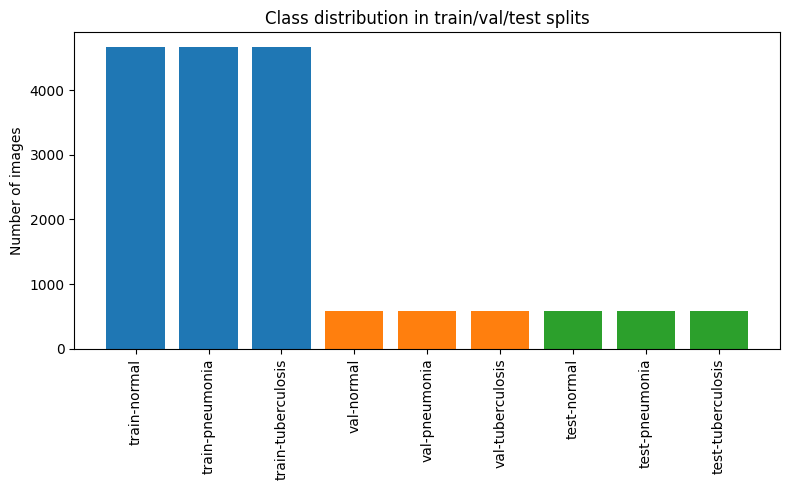

In [ ]:
# Plot class distribution
plt.figure(figsize=(8, 5))
for subset in ['train', 'val', 'test']:
    subset_df = counts_df[counts_df["subset"] == subset]
    plt.bar([f"{subset}-{c}" for c in subset_df["class"]],
            subset_df["count"], label=subset)

plt.xticks(rotation=90)
plt.ylabel("Number of images")
plt.title("Class distribution in train/val/test splits")
plt.tight_layout()
plt.show()

The new splited dataset is class-balanced where each class have nearly the same number of images within each split. This reduces class-bias during training, so the model is less likely to over-predict one class in ambiguous cases.

#### Image Sampaling

Image class: normal
Color mode: RGB
Image height: 512
Image width: 512


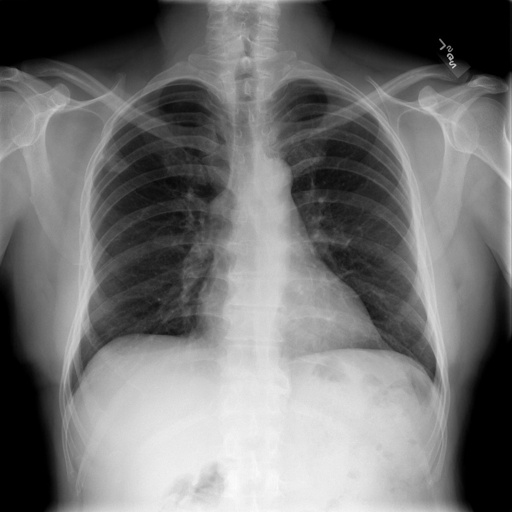

In [ ]:
# Visual inspection of a random training image
cls = random.choice(os.listdir(train_dir))
cls_path = os.path.join(train_dir, cls)

img_name = random.choice([f for f in os.listdir(cls_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
img_path = os.path.join(cls_path, img_name)

img = Image.open(img_path)

print(f"Image class: {cls}")
print(f"Color mode: {img.mode}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

#### Hyperparameters

In [ ]:
BATCH_SIZE = 32 # the number of samples used in each iteration
IMG_SIZE  = 256
EPOCHS = 10
LR = 5e-5 # size of weight update during training

#### Image Transformations

In [ ]:
# Image preprocessing and data augmentation transforms
train_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    # --- ADDED AUGMENTATIONS ---
    transforms.RandomRotation(10),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    # ---------------------------
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]),
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.2), ratio=(0.3, 3.3), value=0)
])

val_test_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
])


#### Image Paths for Visualization

In [ ]:
# Create image path list for visualization
image_path_list = []
for cls in os.listdir(train_dir):
    cls_path = os.path.join(train_dir, cls)
    if os.path.isdir(cls_path):
        imgs = [os.path.join(cls_path, f) for f in os.listdir(cls_path)
                if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        image_path_list.extend(imgs)

In [ ]:
# Visualizing original and transformed images
def plot_transformed_images(image_paths, transform, n=3, seed=42):
    random.seed(seed)
    # sample n random images
    random_image_paths = random.sample(image_paths, k=min(n, len(image_paths)))

    for image_path in random_image_paths:
        try:
            with Image.open(image_path) as img:
                img = img.convert("RGB")

                # Apply transformation and convert to displayable format
                transformed_img = transform(img)
                if isinstance(transformed_img, torch.Tensor):
                    transformed_img = transformed_img.permute(1, 2, 0)  # [C,H,W] → [H,W,C]
                    transformed_img = transformed_img.numpy()

                # Plot before & after
                fig, ax = plt.subplots(1, 2, figsize=(8, 4))
                ax[0].imshow(img)
                ax[0].set_title(f"Original\nSize: {img.size}")
                ax[0].axis("off")

                ax[1].imshow(transformed_img)
                ax[1].set_title(f"Transformed\nSize: {tuple(transform(img).shape)}")
                ax[1].axis("off")

                # Extract class name from parent folder
                cls = os.path.basename(os.path.dirname(image_path))
                fig.suptitle(f"Class: {cls}", fontsize=14)

                plt.tight_layout()
                plt.show()
                plt.close(fig)
        except Exception as e:
            print(f"Skipping {image_path}: {e}")
            continue

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9466565..2.64].


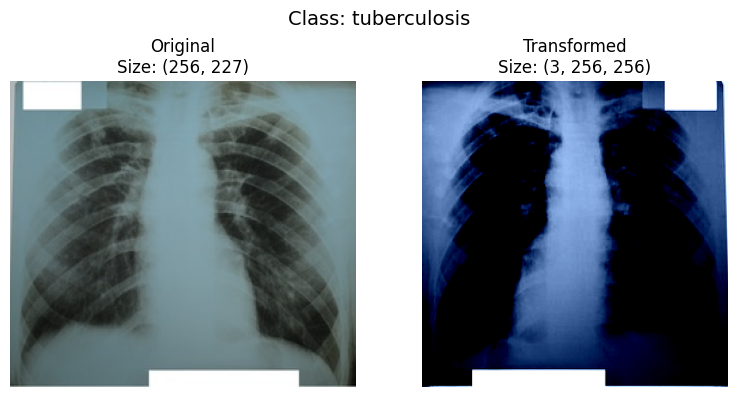

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6051416].


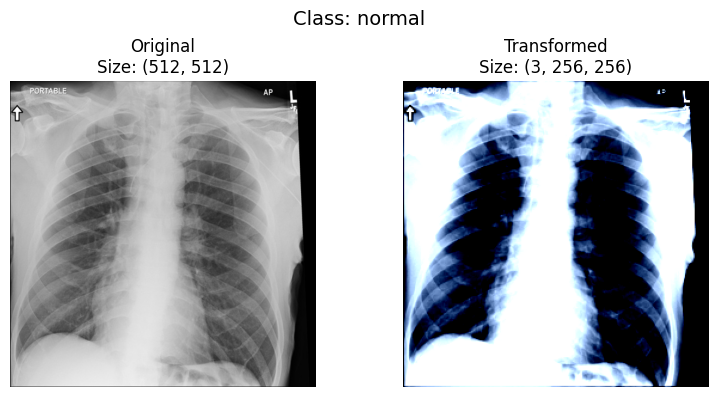

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9980307..2.4308496].


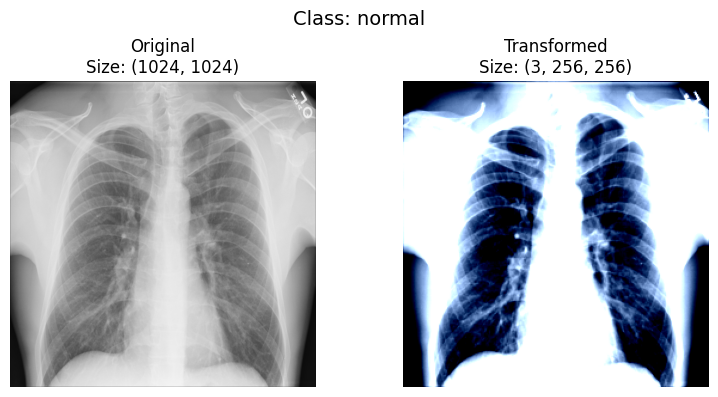

In [ ]:
plot_transformed_images(image_path_list, transform=train_transform, n=3)

#### Cleanup of Notebook Checkpoints

In [ ]:
# Removes .ipynb_checkpoints folders if exist
for root in [train_dir, val_dir, test_dir]:
    chkpt = os.path.join(root, ".ipynb_checkpoints")
    if os.path.isdir(chkpt):
        shutil.rmtree(chkpt)

#### Create Datasets

In [ ]:
# Creating PyTorch datasets
train_data = datasets.ImageFolder(root=train_dir, transform=train_transform)
val_data = datasets.ImageFolder(root=val_dir, transform=val_test_transform)
test_data = datasets.ImageFolder(root=test_dir, transform=val_test_transform)

In [ ]:
from torch.utils.data import WeightedRandomSampler

targets = train_data.targets  # labels from ImageFolder
class_counts = np.bincount(targets)
class_weights = 1.0 / class_counts
sample_weights = [class_weights[t] for t in targets]
sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

#### Create DataLoaders

In [ ]:
# Controls how the data is fed to the models
train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, sampler=sampler)
val_dataloader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
# Number of batches
len(train_dataloader), len(val_dataloader), len(test_dataloader)

(437, 55, 55)

#### Device

In [ ]:
# Decides whether the model will run on GPU or CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


### Machine learning algorithm - kNN

k-Nearest Neighbors is an algorithm that looks at the k closest examples in the training data to decide the class of a new sample. It does not really train a model, it just stores all the data and makes calculations when we ask for a prediction. In our case, K is the number of neighbours we check when deciding the final class.


The function takes all images from a dataset, shrinks them, flattens them into vectors, and returns features and labels so that the k-NN classifier can work with them.

In [ ]:
# Turns the image dataset into vectors
def dataset_to_xy_for_knn(dataset, pool_size, batch_size):
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    X_list, y_list = [], []

    for imgs, labels in loader:
        with torch.no_grad():
            pooled = F.adaptive_avg_pool2d(imgs, output_size=(pool_size, pool_size))
            B = pooled.shape[0]
            X_list.append(pooled.view(B, -1))
            y_list.append(labels)

    X = torch.cat(X_list, dim=0)
    y = torch.cat(y_list, dim=0)
    return X, y

In [ ]:
# Build features for k-NN from your existing datasets
X_train, y_train = dataset_to_xy_for_knn(train_data, pool_size=32, batch_size=64)
X_val,   y_val   = dataset_to_xy_for_knn(val_data,   pool_size=32, batch_size=64)
X_test,  y_test  = dataset_to_xy_for_knn(test_data,  pool_size=32, batch_size=64)

In [ ]:
# Prints the sizes of your data tensors
X_train.shape, y_train.shape, X_test.shape, y_test.shape

(torch.Size([13977, 3072]),
 torch.Size([13977]),
 torch.Size([1749, 3072]),
 torch.Size([1749]))

#### KNN Classifier

In [ ]:
# Define function to calculate distance
def euclidean_distance(X_train, X_test_point):
    distances = torch.sum((X_train - X_test_point) ** 2, dim=1)
    return torch.sqrt(distances)

In [ ]:
# For each test point it finds the K closest training points and picks the most common label among them as the prediction.
def knn(X_train, y_train, X_test, K):
    y_pred = []
    for X_test_point in X_test:
        distances = euclidean_distance(X_train, X_test_point)
        nearest_neighbors = torch.argsort(distances)[:K]
        nearest_labels = y_train[nearest_neighbors]
        predicted_label = torch.mode(nearest_labels).values.item()
        y_pred.append(predicted_label)
    return torch.tensor(y_pred)

#### Model training and testing

In [ ]:
# Ensure correct dtypes
X_train = X_train.float()
X_val   = X_val.float()
X_test  = X_test.float()

y_train = y_train.long()
y_val   = y_val.long()
y_test  = y_test.long()

In [ ]:
# Set number of neighbors
K = 5

# Predict on validation set
y_pred_val = knn(X_train, y_train, X_val, K)
val_accuracy = (y_pred_val == y_val).sum().item() / len(y_val)

# Predict on test set
y_pred_test = knn(X_train, y_train, X_test, K)
test_accuracy = (y_pred_test == y_test).sum().item() / len(y_test)

print(f"KNN Validation Accuracy (K={K}): {val_accuracy * 100:.2f}%")
print(f"KNN Test Accuracy (K={K}): {test_accuracy * 100:.2f}%")

KNN Validation Accuracy (K=5): 66.73%
KNN Test Accuracy (K=5): 68.43%


#### Confusion matrix

In [ ]:
# creates the confusion matrix
cm = torch.zeros((len(train_data.classes), len(train_data.classes)), dtype=torch.int64)

for t, p in zip(y_test, y_pred_test):
    cm[t, p] += 1

cm_np = cm.numpy()
print(cm_np)

[[594 123 208]
 [ 74 498   8]
 [385  13 666]]


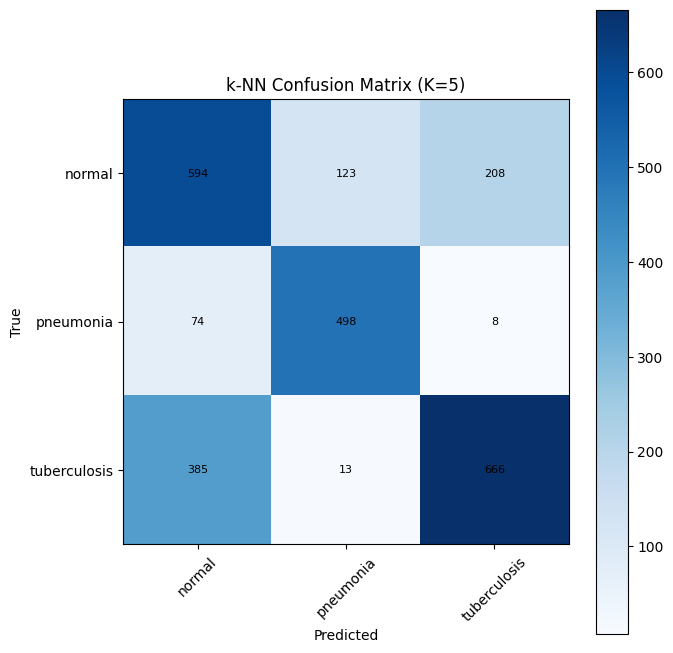

In [ ]:
fig, ax = plt.subplots(figsize=(7,7))
im = ax.imshow(cm_np, cmap="Blues")

ax.set_title(f"k-NN Confusion Matrix (K=5)")
fig.colorbar(im, ax=ax)
ax.set_xticks(range(len(train_data.classes)), train_data.classes, rotation=45)
ax.set_yticks(range(len(train_data.classes)), train_data.classes)
ax.set_xlabel("Predicted")
ax.set_ylabel("True")

for (i, j), v in np.ndenumerate(cm_np):
    ax.text(j, i, int(v), ha="center", va="center", fontsize=8)

plt.tight_layout()
plt.show()

Overall for K = 5, most samples are on the diagonal of the
confusion matrix, so the model usually predicts the correct class. However, it
often confuses tuberculosis with normal and vice versa. Pneumonia is recognized better, but still has some mix ups with the other two classes.

#### Model with best parameters

##### Model training and testing

Several K values were tested (1, 3, 7, 9) to determine the optimal setting for
the k-NN classifier.

In [ ]:
print("Searching for best K:")
for K in [1, 3, 7, 9]:
    y_pred_val = knn(X_train, y_train, X_val, K)
    val_acc = (y_pred_val == y_val).sum().item() / len(y_val)

    y_pred_test = knn(X_train, y_train, X_test, K)
    test_acc = (y_pred_test == y_test).sum().item() / len(y_test)

    print(f"K={K}: Validation={val_acc*100:.2f}%, Test={test_acc*100:.2f}%")

Searching for best K:
K=1: Validation=60.22%, Test=59.52%
K=3: Validation=64.96%, Test=66.41%
K=7: Validation=68.63%, Test=69.60%
K=9: Validation=70.68%, Test=70.96%


The best performance was achieved with K=9, which provided the highest validation and test accuracy.

##### Confusion matrix

In [ ]:
best_K = 9
y_pred_test_best = knn(X_train, y_train, X_test, best_K)

cm = torch.zeros((len(train_data.classes), len(train_data.classes)), dtype=torch.int64)

for t, p in zip(y_test, y_pred_test_best):
    cm[t, p] += 1

cm_np = cm.numpy()

print("Confusion matrix (best K):")
print(cm_np)

Confusion matrix (best K):
[[664 130 131]
 [ 66 504  10]
 [398  11 655]]


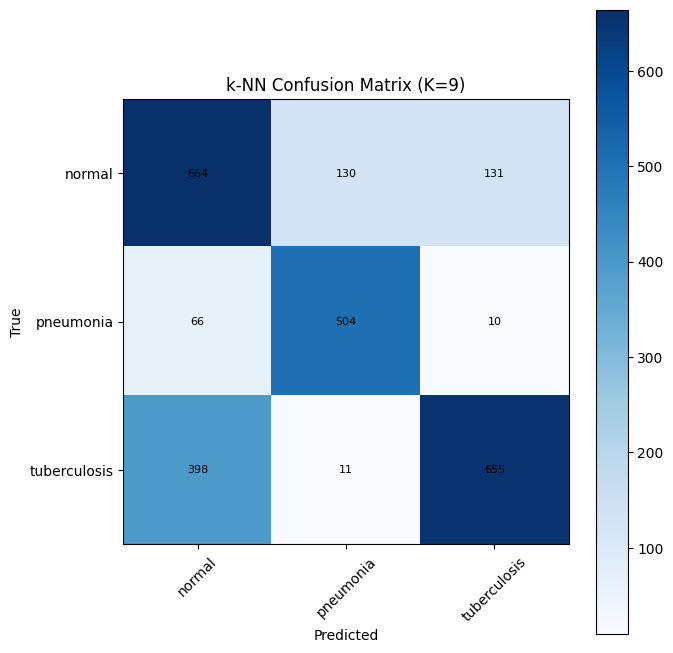

In [ ]:
fig, ax = plt.subplots(figsize=(7,7))
im = ax.imshow(cm_np, cmap="Blues")

ax.set_title(f"k-NN Confusion Matrix (K={best_K})")
fig.colorbar(im, ax=ax)
ax.set_xticks(range(len(train_data.classes)), train_data.classes, rotation=45)
ax.set_yticks(range(len(train_data.classes)), train_data.classes)
ax.set_xlabel("Predicted")
ax.set_ylabel("True")

for (i, j), v in np.ndenumerate(cm_np):
    ax.text(j, i, int(v), ha="center", va="center", fontsize=8)

plt.tight_layout()
plt.show()

For the improved k-NN model with K = 9 the diagonal values are a bit higher, so
overall accuracy is better than with K = 5. So increasing K helps a bit, but the model still struggles to clearly separate normal and tuberculosis cases.<br>

I first used a basic k-NN model with K = 5, and then tried a few other values. The best result was with K = 9.

The K value controls how many neighbours the algorithm looks at when making a
decision. With a small K the model is very sensitive to noise. With a
larger K the predictions become more stable, but if K is too big the model
starts to “average” over many points and can miss smaller patterns in the data.

#### double check the best

In [ ]:
def cosine_distance(X_train, X_test_point):
    X_norm = F.normalize(X_train, dim=1)
    x_norm = F.normalize(X_test_point.unsqueeze(0), dim=1)
    sims = torch.mm(X_norm, x_norm.t()).squeeze(1)    # cosine similarity
    return 1 - sims

In [ ]:
# For each test point it finds the K closest training points and picks the most common label among them as the prediction.
def knn(X_train, y_train, X_test, K):
    y_pred = []
    for X_test_point in X_test:
        distances = cosine_distance(X_train, X_test_point)
        nearest_neighbors = torch.argsort(distances)[:K]
        nearest_labels = y_train[nearest_neighbors]
        predicted_label = torch.mode(nearest_labels).values.item()
        y_pred.append(predicted_label)
    return torch.tensor(y_pred)

In [ ]:
# Set number of neighbors
K = 50

# Predict on validation set
y_pred_val = knn(X_train, y_train, X_val, K)
val_accuracy = (y_pred_val == y_val).sum().item() / len(y_val)

# Predict on test set
y_pred_test = knn(X_train, y_train, X_test, K)
test_accuracy = (y_pred_test == y_test).sum().item() / len(y_test)

print(f"KNN Validation Accuracy (K={K}): {val_accuracy * 100:.2f}%")
print(f"KNN Test Accuracy (K={K}): {test_accuracy * 100:.2f}%")

KNN Validation Accuracy (K=50): 77.55%
KNN Test Accuracy (K=50): 76.44%


In [ ]:
# creates the confusion matrix
cm = torch.zeros((len(train_data.classes), len(train_data.classes)), dtype=torch.int64)

for t, p in zip(y_test, y_pred_test):
    cm[t, p] += 1

cm_np = cm.numpy()
print(cm_np)

[[453 103  27]
 [ 10 563  10]
 [237  25 321]]


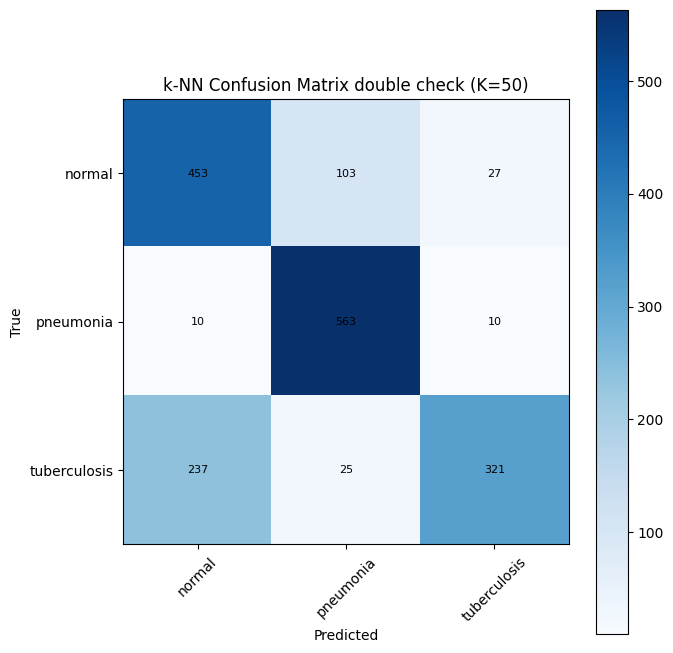

In [ ]:
fig, ax = plt.subplots(figsize=(7,7))
im = ax.imshow(cm_np, cmap="Blues")

ax.set_title(f"k-NN Confusion Matrix double check (K={K})")
fig.colorbar(im, ax=ax)
ax.set_xticks(range(len(train_data.classes)), train_data.classes, rotation=45)
ax.set_yticks(range(len(train_data.classes)), train_data.classes)
ax.set_xlabel("Predicted")
ax.set_ylabel("True")

for (i, j), v in np.ndenumerate(cm_np):
    ax.text(j, i, int(v), ha="center", va="center", fontsize=8)

plt.tight_layout()
plt.show()

### 1st neural network - EfficientNet-B2

The first neural network I used is EfficientNet-B2, a pretrained CNN that
was trained on a large image dataset and already knows how to detect useful
visual features such as edges, textures and shapes. For this task, I keep the
pretrained convolutional part and only replace the last layer so that it
outputs three classes.

In [ ]:
num_classes = len(train_data.classes)
# EfficientNet-B2 Model
model = efficientnet_b2(weights=EfficientNet_B2_Weights.IMAGENET1K_V1)

# last layer has been changeed
in_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(in_features, num_classes)

model = model.to(device)

#### Loss and optimizer

In [ ]:
# Loss function for multi class classification
criterion = nn.CrossEntropyLoss()
# Updates the models weights during training
optimizer = optim.Adam(model.parameters(), lr=LR)

#### Model train and validation

In [ ]:
def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in dataloader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc


def evaluate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

#### training

In [ ]:
train_losses, val_losses = [], []
train_accs,   val_accs   = [], []

for epoch in range(1, EPOCHS + 1):
    train_loss, train_acc = train_one_epoch(model, train_dataloader, criterion, optimizer, device)
    val_loss,   val_acc   = evaluate(model, val_dataloader, criterion, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    print(f"[Epoch {epoch:02d}/{EPOCHS}] "
          f"train_loss={train_loss:.4f}, train_acc={train_acc*100:.2f}% | "
          f"val_loss={val_loss:.4f}, val_acc={val_acc*100:.2f}%")

[Epoch 01/10] train_loss=0.4930, train_acc=75.32% | val_loss=0.3994, val_acc=76.80%
[Epoch 02/10] train_loss=0.3974, train_acc=77.29% | val_loss=0.3728, val_acc=75.53%
[Epoch 03/10] train_loss=0.3680, train_acc=77.57% | val_loss=0.3620, val_acc=76.56%
[Epoch 04/10] train_loss=0.3539, train_acc=78.02% | val_loss=0.3698, val_acc=74.47%
[Epoch 05/10] train_loss=0.3484, train_acc=77.93% | val_loss=0.3521, val_acc=74.15%
[Epoch 06/10] train_loss=0.3430, train_acc=78.00% | val_loss=0.3570, val_acc=75.57%
[Epoch 07/10] train_loss=0.3340, train_acc=78.55% | val_loss=0.3512, val_acc=73.80%
[Epoch 08/10] train_loss=0.3319, train_acc=77.78% | val_loss=0.3542, val_acc=73.64%
[Epoch 09/10] train_loss=0.3290, train_acc=78.64% | val_loss=0.3638, val_acc=72.93%
[Epoch 10/10] train_loss=0.3255, train_acc=78.58% | val_loss=0.3703, val_acc=70.13%


#### Evaluation

EfficientNet-B2 Test Accuracy: 71.08%
Confusion matrix:
[[503  97 325]
 [103 477   0]
 [218   0 846]]


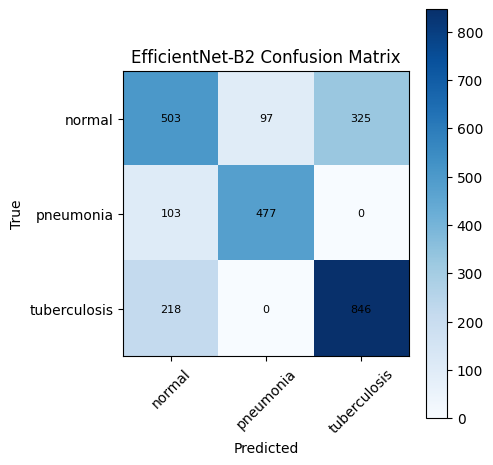

In [ ]:
# Evaluate on test set
model.eval()
correct = 0
total = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_dataloader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        correct += (preds == labels).sum().item()
        total += labels.size(0)

        all_preds.append(preds.cpu())
        all_labels.append(labels.cpu())

test_acc = correct / total
print(f"EfficientNet-B2 Test Accuracy: {test_acc*100:.2f}%")

all_preds  = torch.cat(all_preds)
all_labels = torch.cat(all_labels)

# Confusion matrix
cm = confusion_matrix(all_labels.numpy(), all_preds.numpy())
print("Confusion matrix:")
print(cm)

num_classes = len(train_data.classes)

fig, ax = plt.subplots(figsize=(5, 5))
im = ax.imshow(cm, cmap="Blues")

ax.set_title("EfficientNet-B2 Confusion Matrix")
fig.colorbar(im, ax=ax)
ax.set_xticks(range(num_classes), train_data.classes, rotation=45)
ax.set_yticks(range(num_classes), train_data.classes)
ax.set_xlabel("Predicted")
ax.set_ylabel("True")

for (i, j), v in np.ndenumerate(cm):
    ax.text(j, i, int(v), ha='center', va='center', fontsize=8)

plt.tight_layout()
plt.show()

Overall for the EfficientNet-B2 model, most samples are on the diagonal of the confusion matrix, so the network usually predicts the correct class. However, it still strongly confuses tuberculosis with normal and the other way around. Pneumonia is recognised better, with fewer mix-ups with the other two classes.

#### Model with best parameters

For the best parameters I used a higher learning rate and fewer epochs.
The higher LR lets the network learn faster, and training for fewer epochs helps prevent overfitting, so this version reaches a higher test accuracy than the initial setup.

In [ ]:
BEST_EPOCHS = 5
BEST_LR = 1e-4

In [ ]:
BEST_optimizer = optim.Adam(model.parameters(), lr=BEST_LR)

In [ ]:
train_losses, val_losses = [], []
train_accs,   val_accs   = [], []

for epoch in range(1, BEST_EPOCHS + 1):
    train_loss, train_acc = train_one_epoch(model, train_dataloader, criterion, BEST_optimizer, device)
    val_loss,   val_acc   = evaluate(model, val_dataloader, criterion, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    print(f"[Epoch {epoch:02d}/{EPOCHS}] "
          f"train_loss={train_loss:.4f}, train_acc={train_acc*100:.2f}% | "
          f"val_loss={val_loss:.4f}, val_acc={val_acc*100:.2f}%")

[Epoch 01/5] train_loss=0.4583, train_acc=76.08% | val_loss=0.3835, val_acc=76.80%
[Epoch 02/5] train_loss=0.3771, train_acc=77.43% | val_loss=0.3632, val_acc=75.65%
[Epoch 03/5] train_loss=0.3563, train_acc=77.41% | val_loss=0.3708, val_acc=75.41%
[Epoch 04/5] train_loss=0.3500, train_acc=77.52% | val_loss=0.3427, val_acc=75.57%
[Epoch 05/5] train_loss=0.3404, train_acc=77.79% | val_loss=0.3480, val_acc=76.16%


EfficientNet-B2 Test Accuracy: 77.23%
Confusion matrix (CNN):
[[843  67  15]
 [110 470   0]
 [393   0 671]]


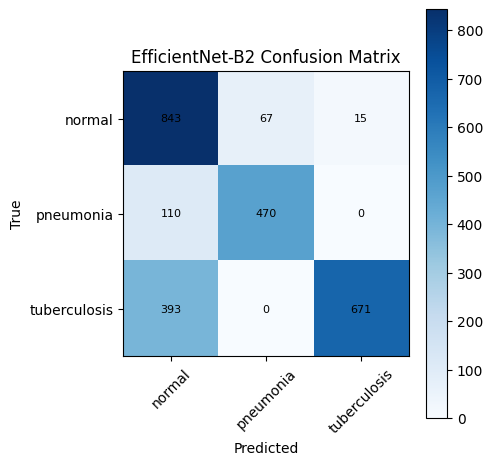

In [ ]:
# Evaluate on test set
model.eval()
correct = 0
total = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_dataloader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        correct += (preds == labels).sum().item()
        total += labels.size(0)

        all_preds.append(preds.cpu())
        all_labels.append(labels.cpu())

test_acc = correct / total
print(f"EfficientNet-B2 Test Accuracy: {test_acc*100:.2f}%")

all_preds  = torch.cat(all_preds)
all_labels = torch.cat(all_labels)

# Confusion matrix
num_classes = len(train_data.classes)
cm = confusion_matrix(all_labels.numpy(), all_preds.numpy())
print("Confusion matrix (CNN):")
print(cm)

fig, ax = plt.subplots(figsize=(5, 5))
im = ax.imshow(cm, cmap="Blues")

ax.set_title("EfficientNet-B2 Confusion Matrix")
fig.colorbar(im, ax=ax)
ax.set_xticks(range(num_classes), train_data.classes, rotation=45)
ax.set_yticks(range(num_classes), train_data.classes)
ax.set_xlabel("Predicted")
ax.set_ylabel("True")

for (i, j), v in np.ndenumerate(cm):
    ax.text(j, i, int(v), ha='center', va='center', fontsize=8)

plt.tight_layout()
plt.show()

For the tuned EfficientNet-B2 model the diagonal values in the confusion matrix are higher, so overall accuracy is clearly better than in the first CNN run. Normal and pneumonia are recognised very well, and tuberculosis also improves, but the model still sometimes confuses tuberculosis with normal cases.

I first used a basic EfficientNet-B2 setup: lower learning rate and more epochs, and then tried a few combinations of learning rate and number of epochs. The best result was with a higher learning rate and fewer epochs. The learning rate controls how big the weight updates are, too small and the model learns slowly, too large and it can become unstable. The number of epochs controls how long we train, too many can cause overfitting, a few can underfit.

#### double check

In [ ]:
BEST_EPOCHS = 5
BEST_LR = 1e-4

In [ ]:

best_criterion = nn.CrossEntropyLoss()
BEST_optimizer = optim.Adam(model.parameters(), lr=BEST_LR)

In [ ]:
import copy

train_losses, val_losses = [], []
train_accs,   val_accs   = [], []

best_val_acc = 0.0
best_state   = copy.deepcopy(model.state_dict())
best_epoch   = 0

for epoch in range(1, BEST_EPOCHS + 1):
    train_loss, train_acc = train_one_epoch(
        model, train_dataloader, best_criterion, BEST_optimizer, device
    )
    val_loss,   val_acc   = evaluate(
        model, val_dataloader, best_criterion, device
    )

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    print(f"[Epoch {epoch:02d}/{BEST_EPOCHS}] "
          f"train_loss={train_loss:.4f}, train_acc={train_acc*100:.2f}% | "
          f"val_loss={val_loss:.4f}, val_acc={val_acc*100:.2f}%")

    # keep best epoch by validation accuracy
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_state   = copy.deepcopy(model.state_dict())
        best_epoch   = epoch

print(f"\nBest validation accuracy: {best_val_acc*100:.2f}% at epoch {best_epoch}")

[Epoch 01/5] train_loss=0.4739, train_acc=77.37% | val_loss=0.3756, val_acc=81.79%
[Epoch 02/5] train_loss=0.3927, train_acc=80.01% | val_loss=0.3842, val_acc=76.29%
[Epoch 03/5] train_loss=0.3716, train_acc=80.77% | val_loss=0.3519, val_acc=81.73%
[Epoch 04/5] train_loss=0.3651, train_acc=81.09% | val_loss=0.3544, val_acc=82.13%
[Epoch 05/5] train_loss=0.3551, train_acc=81.28% | val_loss=0.3527, val_acc=80.36%

Best validation accuracy: 82.13% at epoch 4


EfficientNet-B2 Test Accuracy: 81.13%
Confusion matrix (CNN):
[[476 103   4]
 [  0 583   0]
 [223   0 360]]
Recall normal: 81.65%
Recall pneumonia: 100.00%
Recall tuberculosis: 61.75%

Classification report:
              precision    recall  f1-score   support

      normal       0.68      0.82      0.74       583
   pneumonia       0.85      1.00      0.92       583
tuberculosis       0.99      0.62      0.76       583

    accuracy                           0.81      1749
   macro avg       0.84      0.81      0.81      1749
weighted avg       0.84      0.81      0.81      1749



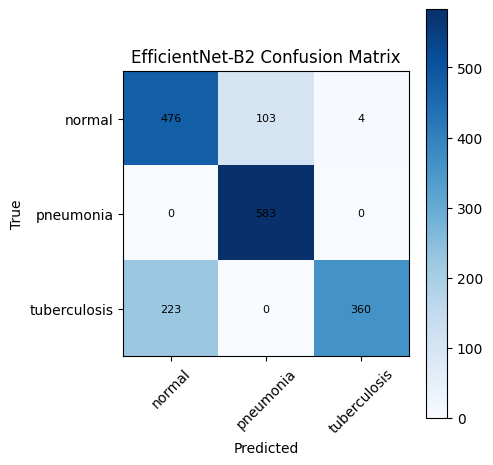

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

model.load_state_dict(best_state)

model.eval()
correct = 0
total = 0
all_preds = []
all_labels = []
all_probs  = []

with torch.no_grad():
    for images, labels in test_dataloader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        probs   = torch.softmax(outputs, dim=1)

        _, preds = torch.max(outputs, 1)

        correct += (preds == labels).sum().item()
        total   += labels.size(0)

        all_preds.append(preds.cpu())
        all_labels.append(labels.cpu())
        all_probs.append(probs.cpu())

test_acc = correct / total
print(f"EfficientNet-B2 Test Accuracy: {test_acc*100:.2f}%")

all_preds  = torch.cat(all_preds).numpy()
all_labels = torch.cat(all_labels).numpy()
all_probs  = torch.cat(all_probs).numpy()

# Confusion matrix
num_classes = len(train_data.classes)
cm = confusion_matrix(all_labels, all_preds)
print("Confusion matrix (CNN):")
print(cm)

# Per-class recall from confusion matrix
recalls = cm.diagonal() / cm.sum(axis=1)
for cls_name, r in zip(train_data.classes, recalls):
    print(f"Recall {cls_name}: {r*100:.2f}%")

# Full classification report: precision / recall / F1 for each class
print("\nClassification report:")
print(classification_report(all_labels, all_preds, target_names=train_data.classes, digits=2))

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(5, 5))
im = ax.imshow(cm, cmap="Blues")

ax.set_title("EfficientNet-B2 Confusion Matrix")
fig.colorbar(im, ax=ax)
ax.set_xticks(range(num_classes), train_data.classes, rotation=45)
ax.set_yticks(range(num_classes), train_data.classes)
ax.set_xlabel("Predicted")
ax.set_ylabel("True")

for (i, j), v in np.ndenumerate(cm):
    ax.text(j, i, int(v), ha='center', va='center', fontsize=8)

plt.tight_layout()
plt.show()


### 2nd network -MLP

The second neural network is a Multilayer Perceptron (MLP).
It takes the pooled image features, passes them through one hidden fully connected layer, and outputs 3 values for the three classes. Unlike k-NN, the MLP actually learns weights, so it can build a more flexible decision boundary between normal, pneumonia and tuberculosis.

#### MLP hyperparameters

In [ ]:
MLP_EPOCHS = 10
MLP_LR = 5e-4
HIDDEN_DIM = 256

#### Model

In [ ]:
input_dim   = X_train.shape[1]
num_classes = len(train_data.classes)
print("MLP input_dim:", input_dim, "num_classes:", num_classes)

mlp_model = nn.Sequential(
    nn.Linear(input_dim, HIDDEN_DIM),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(HIDDEN_DIM, num_classes)
).to(device)

MLP input_dim: 3072 num_classes: 3


In [ ]:
mlp_criterion = nn.CrossEntropyLoss()
mlp_optimizer = optim.Adam(mlp_model.parameters(), lr=MLP_LR)

#### Traning and Validation

In [ ]:
mlp_train_losses, mlp_val_losses = [], []
mlp_train_accs,   mlp_val_accs   = [], []

for epoch in range(1, MLP_EPOCHS + 1):
    # Train
    mlp_model.train()
    Xb = X_train.to(device)
    yb = y_train.to(device)

    mlp_optimizer.zero_grad()
    outputs = mlp_model(Xb)
    loss = mlp_criterion(outputs, yb)
    loss.backward()
    mlp_optimizer.step()

    _, preds = torch.max(outputs, 1)
    train_acc = (preds == yb).sum().item() / len(yb)
    train_loss = loss.item()

    # Validation
    mlp_model.eval()
    with torch.no_grad():
        Xv = X_val.to(device)
        yv = y_val.to(device)

        val_outputs = mlp_model(Xv)
        val_loss    = mlp_criterion(val_outputs, yv).item()
        _, val_preds = torch.max(val_outputs, 1)
        val_acc     = (val_preds == yv).sum().item() / len(yv)

    mlp_train_losses.append(train_loss)
    mlp_val_losses.append(val_loss)
    mlp_train_accs.append(train_acc)
    mlp_val_accs.append(val_acc)

    print(f"[MLP {epoch:02d}/{MLP_EPOCHS}] "
          f"train_loss={train_loss:.4f}, train_acc={train_acc*100:.2f}% | "
          f"val_loss={val_loss:.4f}, val_acc={val_acc*100:.2f}%")

[MLP 01/10] train_loss=0.6449, train_acc=68.73% | val_loss=0.6303, val_acc=68.55%
[MLP 02/10] train_loss=0.6365, train_acc=68.93% | val_loss=0.6241, val_acc=68.86%
[MLP 03/10] train_loss=0.6293, train_acc=69.27% | val_loss=0.6188, val_acc=69.14%
[MLP 04/10] train_loss=0.6236, train_acc=69.19% | val_loss=0.6140, val_acc=69.61%
[MLP 05/10] train_loss=0.6168, train_acc=69.70% | val_loss=0.6094, val_acc=70.17%
[MLP 06/10] train_loss=0.6096, train_acc=69.87% | val_loss=0.6045, val_acc=70.17%
[MLP 07/10] train_loss=0.6043, train_acc=70.12% | val_loss=0.5993, val_acc=70.05%
[MLP 08/10] train_loss=0.6013, train_acc=69.93% | val_loss=0.5939, val_acc=70.09%
[MLP 09/10] train_loss=0.5940, train_acc=69.90% | val_loss=0.5888, val_acc=70.40%
[MLP 10/10] train_loss=0.5883, train_acc=70.35% | val_loss=0.5842, val_acc=70.76%


#### Evaluetion

MLP Test Accuracy: 71.31%
Confusion matrix (MLP):
[[614 134 177]
 [ 45 517  18]
 [352  11 701]]


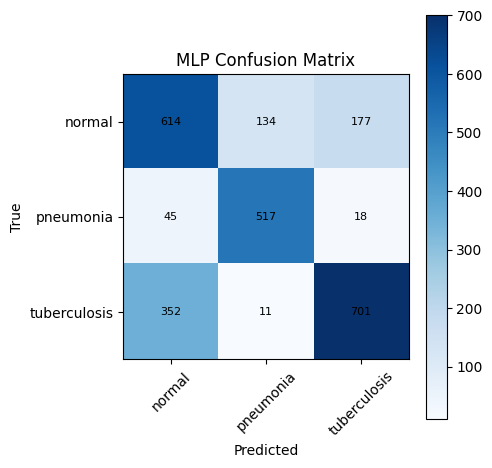

In [ ]:
mlp_model.eval()
with torch.no_grad():
    Xt = X_test.to(device)
    yt = y_test.to(device)

    test_outputs = mlp_model(Xt)
    _, test_preds = torch.max(test_outputs, 1)
    mlp_test_acc  = (test_preds == yt).sum().item() / len(yt)

print(f"MLP Test Accuracy: {mlp_test_acc*100:.2f}%")

# Confusion matrix
cm_mlp = confusion_matrix(y_test.numpy(), test_preds.cpu().numpy())
print("Confusion matrix (MLP):")
print(cm_mlp)

fig, ax = plt.subplots(figsize=(5, 5))
im = ax.imshow(cm_mlp, cmap="Blues")

ax.set_title("MLP Confusion Matrix")
fig.colorbar(im, ax=ax)
ax.set_xticks(range(num_classes), train_data.classes, rotation=45)
ax.set_yticks(range(num_classes), train_data.classes)
ax.set_xlabel("Predicted")
ax.set_ylabel("True")

for (i, j), v in np.ndenumerate(cm_mlp):
    ax.text(j, i, int(v), ha='center', va='center', fontsize=8)

plt.tight_layout()
plt.show()

Overall for the first MLP model, most samples are on the diagonal, so the model usually predicts the correct class. Pneumonia is recognised quite well, but there is still a lot of confusion between tuberculosis and normal. many TB images are predicted as normal and some normal images as TB.

#### Model with best parameters

For the best model, I increased the number of epochs from 10 to 25 and the hidden layer from 256 to 512 units so that the network can learn longer and capture more complex patterns in the data. I also added a small weight decay
(1e-4) to reduce overfitting.

In [ ]:
MLP_EPOCHS = 25
MLP_LR = 5e-4
HIDDEN_DIM = 512
Weight_Decay = 1e-4

In [ ]:
input_dim   = X_train.shape[1]
num_classes = len(train_data.classes)
print("MLP input_dim:", input_dim, "num_classes:", num_classes)

mlp_model = nn.Sequential(
    nn.Linear(input_dim, HIDDEN_DIM),
    nn.ReLU(),
    nn.Dropout(0.2), # Reduced dropout
    nn.Linear(HIDDEN_DIM, num_classes)
).to(device)

MLP input_dim: 768 num_classes: 3


In [ ]:
mlp_criterion = nn.CrossEntropyLoss()
mlp_optimizer = optim.Adam(mlp_model.parameters(), lr=MLP_LR, weight_decay=Weight_Decay)

In [ ]:
mlp_train_losses, mlp_val_losses = [], []
mlp_train_accs,   mlp_val_accs   = [], []

for epoch in range(1, MLP_EPOCHS + 1):
    # Train
    mlp_model.train()
    Xb = X_train.to(device)
    yb = y_train.to(device)

    mlp_optimizer.zero_grad()
    outputs = mlp_model(Xb)
    loss = mlp_criterion(outputs, yb)
    loss.backward()
    mlp_optimizer.step()

    _, preds = torch.max(outputs, 1)
    train_acc = (preds == yb).sum().item() / len(yb)
    train_loss = loss.item()

    # Validation
    mlp_model.eval()
    with torch.no_grad():
        Xv = X_val.to(device)
        yv = y_val.to(device)

        val_outputs = mlp_model(Xv)
        val_loss    = mlp_criterion(val_outputs, yv).item()
        _, val_preds = torch.max(val_outputs, 1)
        val_acc     = (val_preds == yv).sum().item() / len(yv)

    mlp_train_losses.append(train_loss)
    mlp_val_losses.append(val_loss)
    mlp_train_accs.append(train_acc)
    mlp_val_accs.append(val_acc)

    print(f"[MLP {epoch:02d}/{MLP_EPOCHS}] "
          f"train_loss={train_loss:.4f}, train_acc={train_acc*100:.2f}% | "
          f"val_loss={val_loss:.4f}, val_acc={val_acc*100:.2f}%")

[MLP 01/25] train_loss=0.5468, train_acc=72.11% | val_loss=0.5476, val_acc=72.06%
[MLP 02/25] train_loss=0.5446, train_acc=72.19% | val_loss=0.5452, val_acc=71.63%
[MLP 03/25] train_loss=0.5417, train_acc=72.37% | val_loss=0.5433, val_acc=71.90%
[MLP 04/25] train_loss=0.5377, train_acc=72.99% | val_loss=0.5416, val_acc=72.06%
[MLP 05/25] train_loss=0.5371, train_acc=72.85% | val_loss=0.5400, val_acc=72.14%
[MLP 06/25] train_loss=0.5327, train_acc=73.06% | val_loss=0.5384, val_acc=72.30%
[MLP 07/25] train_loss=0.5311, train_acc=72.90% | val_loss=0.5362, val_acc=72.53%
[MLP 08/25] train_loss=0.5300, train_acc=72.93% | val_loss=0.5340, val_acc=72.61%
[MLP 09/25] train_loss=0.5284, train_acc=72.97% | val_loss=0.5321, val_acc=72.69%
[MLP 10/25] train_loss=0.5258, train_acc=73.19% | val_loss=0.5303, val_acc=72.69%
[MLP 11/25] train_loss=0.5220, train_acc=73.17% | val_loss=0.5290, val_acc=72.69%
[MLP 12/25] train_loss=0.5219, train_acc=73.30% | val_loss=0.5280, val_acc=72.89%
[MLP 13/25] trai


MLP Test Accuracy: 74.08%

Confusion matrix (MLP):
[[670 102 153]
 [ 48 516  16]
 [339   8 717]]


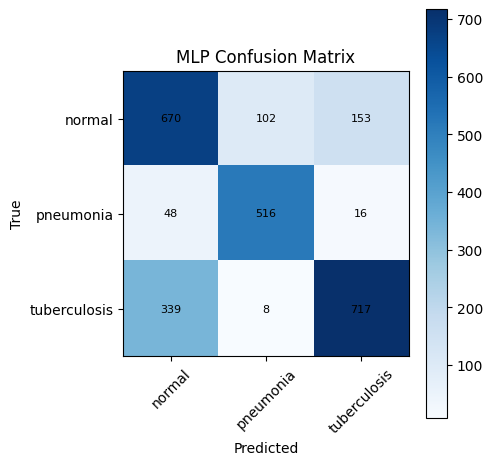

In [ ]:
mlp_model.eval()
with torch.no_grad():
    Xt = X_test.to(device)
    yt = y_test.to(device)

    test_outputs = mlp_model(Xt)
    _, test_preds = torch.max(test_outputs, 1)
    mlp_test_acc  = (test_preds == yt).sum().item() / len(yt)

print(f"\nMLP Test Accuracy: {mlp_test_acc*100:.2f}%")

# Confusion matrix
cm_mlp = confusion_matrix(y_test.numpy(), test_preds.cpu().numpy())
print("\nConfusion matrix (MLP):")
print(cm_mlp)

fig, ax = plt.subplots(figsize=(5, 5))
im = ax.imshow(cm_mlp, cmap="Blues")

ax.set_title(f"MLP Confusion Matrix")
fig.colorbar(im, ax=ax)
ax.set_xticks(range(num_classes), train_data.classes, rotation=45)
ax.set_yticks(range(num_classes), train_data.classes)
ax.set_xlabel("Predicted")
ax.set_ylabel("True")

for (i, j), v in np.ndenumerate(cm_mlp):
    ax.text(j, i, int(v), ha='center', va='center', fontsize=8)

plt.tight_layout()
plt.show()

#### double check

In [ ]:
import copy

In [ ]:
MLP_EPOCHS = 35
MLP_LR = 3e-4
HIDDEN_DIM = 512
Weight_Decay = 1e-4

In [ ]:
input_dim   = X_train.shape[1]
num_classes = len(train_data.classes)
print("MLP input_dim:", input_dim, "num_classes:", num_classes)

mlp_model = nn.Sequential(
    nn.Linear(input_dim, HIDDEN_DIM),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(HIDDEN_DIM, num_classes)
).to(device)


MLP input_dim: 3072 num_classes: 3


In [ ]:
from sklearn.utils.class_weight import compute_class_weight

y_train_np = y_train.cpu().numpy()

classes = np.unique(y_train_np)
weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_np),
    y=y_train_np
)


# Convert weights to a PyTorch tensor and move to the correct device (e.g., 'cuda' or 'cpu')
class_weights = torch.tensor(weights, dtype=torch.float).to(device)

print(f"Calculated class weights: {class_weights}")

Calculated class weights: tensor([1., 1., 1.], device='cuda:0')


In [ ]:
mlp_criterion = nn.CrossEntropyLoss(weight=class_weights)
mlp_optimizer = optim.Adam(mlp_model.parameters(),
                           lr=MLP_LR,
                           weight_decay=Weight_Decay)

In [ ]:
mlp_train_losses, mlp_val_losses = [], []
mlp_train_accs,   mlp_val_accs   = [], []

best_val_acc   = 0.0
best_mlp_state = None
best_epoch     = 0

for epoch in range(1, MLP_EPOCHS + 1):
    # ----- Train -----
    mlp_model.train()
    Xb = X_train.to(device)
    yb = y_train.to(device)

    mlp_optimizer.zero_grad()
    outputs = mlp_model(Xb)
    loss = mlp_criterion(outputs, yb)
    loss.backward()
    mlp_optimizer.step()

    _, preds = torch.max(outputs, 1)
    train_acc  = (preds == yb).sum().item() / len(yb)
    train_loss = loss.item()

    # ----- Validation -----
    mlp_model.eval()
    with torch.no_grad():
        Xv = X_val.to(device)
        yv = y_val.to(device)

        val_outputs = mlp_model(Xv)
        val_loss    = mlp_criterion(val_outputs, yv).item()
        _, val_preds = torch.max(val_outputs, 1)
        val_acc     = (val_preds == yv).sum().item() / len(yv)

    mlp_train_losses.append(train_loss)
    mlp_val_losses.append(val_loss)
    mlp_train_accs.append(train_acc)
    mlp_val_accs.append(val_acc)

    print(f"[MLP {epoch:02d}/{MLP_EPOCHS}] "
          f"train_loss={train_loss:.4f}, train_acc={train_acc*100:.2f}% | "
          f"val_loss={val_loss:.4f}, val_acc={val_acc*100:.2f}%")

    # ---- keep best epoch by validation accuracy ----
    if val_acc > best_val_acc:
        best_val_acc   = val_acc
        best_mlp_state = mlp_model.state_dict()
        best_epoch     = epoch

print(f"\nBest MLP validation accuracy: {best_val_acc*100:.2f}% at epoch {best_epoch}")


[MLP 01/35] train_loss=1.1086, train_acc=36.62% | val_loss=0.8688, val_acc=61.74%
[MLP 02/35] train_loss=1.0075, train_acc=54.22% | val_loss=0.7227, val_acc=70.10%
[MLP 03/35] train_loss=0.8476, train_acc=62.12% | val_loss=0.7711, val_acc=62.77%
[MLP 04/35] train_loss=0.8745, train_acc=59.63% | val_loss=0.6671, val_acc=68.50%
[MLP 05/35] train_loss=0.7811, train_acc=63.09% | val_loss=0.6279, val_acc=73.94%
[MLP 06/35] train_loss=0.7587, train_acc=65.92% | val_loss=0.6498, val_acc=74.28%
[MLP 07/35] train_loss=0.7804, train_acc=64.46% | val_loss=0.6437, val_acc=74.46%
[MLP 08/35] train_loss=0.7558, train_acc=65.89% | val_loss=0.6180, val_acc=74.68%
[MLP 09/35] train_loss=0.7159, train_acc=67.97% | val_loss=0.6016, val_acc=74.23%
[MLP 10/35] train_loss=0.7001, train_acc=68.71% | val_loss=0.5964, val_acc=73.94%
[MLP 11/35] train_loss=0.7077, train_acc=67.83% | val_loss=0.5890, val_acc=73.25%
[MLP 12/35] train_loss=0.7072, train_acc=67.03% | val_loss=0.5763, val_acc=74.17%
[MLP 13/35] trai


MLP Test Accuracy (best epoch): 76.39%

Confusion matrix (MLP):
[[451 100  32]
 [ 17 551  15]
 [232  17 334]]


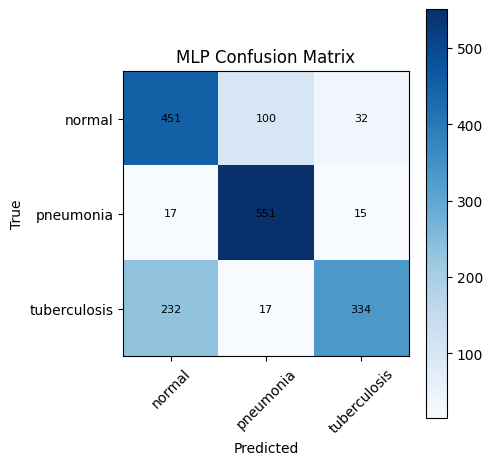

In [ ]:
mlp_model.load_state_dict(best_mlp_state)
mlp_model.eval()

with torch.no_grad():
    Xt = X_test.to(device)
    yt = y_test.to(device)

    test_outputs = mlp_model(Xt)
    _, test_preds = torch.max(test_outputs, 1)
    mlp_test_acc  = (test_preds == yt).sum().item() / len(yt)

print(f"\nMLP Test Accuracy (best epoch): {mlp_test_acc*100:.2f}%")

cm_mlp = confusion_matrix(y_test.numpy(), test_preds.cpu().numpy())
print("\nConfusion matrix (MLP):")
print(cm_mlp)

fig, ax = plt.subplots(figsize=(5, 5))
im = ax.imshow(cm_mlp, cmap="Blues")

ax.set_title("MLP Confusion Matrix")
fig.colorbar(im, ax=ax)
ax.set_xticks(range(num_classes), train_data.classes, rotation=45)
ax.set_yticks(range(num_classes), train_data.classes)
ax.set_xlabel("Predicted")
ax.set_ylabel("True")

for (i, j), v in np.ndenumerate(cm_mlp):
    ax.text(j, i, int(v), ha='center', va='center', fontsize=8)

plt.tight_layout()
plt.show()


For the tuned MLP model the diagonal values in the confusion matrix are higher,
so overall accuracy is better than in the first MLP run. Normal,
pneumonia and tuberculosis all have more correct predictions, but the model
still sometimes confuses tuberculosis with normal cases.

I first used a basic MLP setup with a smaller hidden layer, higher dropout and
fewer epochs, and then tried a few combinations of hidden size, dropout,
weight decay and number of epochs. The best result was with a larger hidden
layer 512, slightly lower dropout and weight decay, trained
for more epochs. The hidden size controls how much capacity the model has to
learn patterns, while dropout and weight decay act as regularisation to reduce
overfitting.


### Comparison of the best models

In [ ]:
results = pd.DataFrame([
    {
        "Model": "k-NN",
        "Type": "Classical ML",
        "Key parameters": "K = 9, pool_size = 16",
        "Val accuracy (%)": 70.68,
        "Test accuracy (%)": 70.96
    },
    {
        "Model": "Multilayer Perceptron",
        "Type": "Neural network",
        "Key parameters": "hidden=512, dropout=0.2, wd=1e-4, epochs=25",
        "Val accuracy (%)": 73.13,
        "Test accuracy (%)": 74.08
    },
    {
        "Model": "EfficientNet-B2",
        "Type": "CNN",
        "Key parameters": "LR=1e-4, epochs=5",
        "Val accuracy (%)": 76.80,
        "Test accuracy (%)": 77.23
    },
])

results


,Model,Type,Key parameters,Val accuracy (%),Test accuracy (%)
0,k-NN,Classical ML,"K = 9, pool_size = 16",70.68,70.96
1,Multilayer Perceptron,Neural network,"hidden=512, dropout=0.2, wd=1e-4, epochs=25",73.13,74.08
2,EfficientNet-B2,CNN,"LR=1e-4, epochs=5",76.80,77.23


From all three models in the table, EfficientNet-B2 showed the best performance, achieving the highest validation and test accuracy on the chest X-ray classification task.

In [ ]:
results = pd.DataFrame([
    {
        "Model": "k-NN",
        "Type": "Classical ML",
        "Key parameters": "cosine distance, K=50, pool_size=32",
        "Val accuracy (%)": 77.55,
        "Test accuracy (%)": 76.44,
    },
    {
        "Model": "Multilayer Perceptron",
        "Type": "Neural network",
        "Key parameters": "hidden=512, dropout=0.3, wd=1e-4, lr=3e-4, epochs=35 (best epoch), class-weighted CE",
        "Val accuracy (%)": 78.52,
        "Test accuracy (%)": 76.39,
    },
    {
        "Model": "EfficientNet-B2",
        "Type": "CNN",
        "Key parameters": "pretrained, Adam, lr=1e-4, epochs=5 (best epoch by val)",
        "Val accuracy (%)": 82.13,
        "Test accuracy (%)": 81.13,
    },
], columns=["Model", "Type", "Key parameters", "Val accuracy (%)", "Test accuracy (%)"])

results

,Model,Type,Key parameters,Val accuracy (%),Test accuracy (%)
0,k-NN,Classical ML,"cosine distance, K=50, pool_size=32",77.55,76.44
1,Multilayer Perceptron,Neural network,"hidden=512, dropout=0.3, wd=1e-4, lr=3e-4, epo...",78.52,76.39
2,EfficientNet-B2,CNN,"pretrained, Adam, lr=1e-4, epochs=5 (best epoc...",82.13,81.13


#### Everage of Sempling

In [ ]:
results = pd.DataFrame([
    {
        "Model": "k-NN",
        "Type": "Classical ML",
        "Test acc 1": 76.44,
        "Test acc 2": 73.18,
        "Test acc 3": 71.7,
        "Test acc 4": 72.5,
        "Test acc 5": 73.47,
        "Average": 73.458,
    },
    {
        "Model": "Multilayer Perceptron",
        "Type": "MLP",
        "Test acc 1": 76.39,
        "Test acc 2": 74.5,
        "Test acc 3": 74.56,
        "Test acc 4": 74.33,
        "Test acc 5": 75.7,
        "Average": 75.096,
    },
    {
        "Model": "EfficientNet-B2",
        "Type": "CNN",
        "Test acc 1": 81.13,
        "Test acc 2": 79.93,
        "Test acc 3": 80.67,
        "Test acc 4": 82.28,
        "Test acc 5": 81.36,
        "Average": 81.074,
    },
    ], columns=["Model", "Type", "Test acc 1", "Test acc 2", "Test acc 3", "Test acc 4", "Test acc 5", "Average"])

results

,Model,Type,Test acc 1,Test acc 2,Test acc 3,Test acc 4,Test acc 5,Average
0,k-NN,Classical ML,76.44,73.18,71.70,72.50,73.47,73.458
1,Multilayer Perceptron,MLP,76.39,74.50,74.56,74.33,75.70,75.096
2,EfficientNet-B2,CNN,81.13,79.93,80.67,82.28,81.36,81.074


### Conclusions

Overall, three models were trained to classify chest X-ray images into normal, pneumonia and tuberculosis classes. The work started with preprocessing the images - resizing them, normalizing them and applying simple augmentation. Then three models were created and tested: a k-NN model, an MLP and a CNN based on EfficientNet-B2. The best results came from EfficientNet-B2, with around 77% test accuracy. It still makes some mistakes and could probably be improved a bit more, but overall it handles the three classes better than the simpler models. In the future, the results could be improved further with stronger augmentation, class balancing or longer fine-tuning.